# Data Analysis

In [180]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random     as rnd
import sklearn    as skl
import skopt      as sko
import numpy      as np
import pandas     as pd
import seaborn as sns
from tensorflow import keras
import os

In [101]:
df = pd.read_hdf('data/cicy3o.h5')

In [102]:
df.describe()

,euler,h11,h21,num_cp,num_eqs,min_dim_cp,max_dim_cp,mean_dim_cp,median_dim_cp,num_cp_1,...,num_over,num_ex,min_deg_eqs,max_deg_eqs,mean_deg_eqs,median_deg_eqs,rank_matrix,norm_matrix,isprod,favour
count,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,...,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.0
mean,-42.649937,7.419772,28.744740,6.540684,7.301648,1.020152,2.708999,1.616977,1.409252,3.572750,...,3.760963,2.239037,2.027503,3.277186,2.378916,2.172687,6.216857,4.242878,0.002788,0.0
std,20.589891,2.250891,8.577282,1.596812,2.087152,0.184930,0.791630,0.296287,0.482226,1.442995,...,1.163259,1.163259,0.212140,0.651334,0.334796,0.407180,1.723061,0.333623,0.052734,0.0
min,-200.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,0.000000,0.0
25%,-52.000000,6.000000,23.000000,5.000000,6.000000,1.000000,2.000000,1.428571,1.000000,3.000000,...,3.000000,1.000000,2.000000,3.000000,2.166667,2.000000,5.000000,4.000000,0.000000,0.0
50%,-40.000000,7.000000,27.000000,7.000000,7.000000,1.000000,3.000000,1.571429,1.000000,4.000000,...,4.000000,2.000000,2.000000,3.000000,2.285714,2.000000,6.000000,4.242641,0.000000,0.0
75%,-28.000000,9.000000,33.000000,8.000000,9.000000,1.000000,3.000000,1.714286,2.000000,5.000000,...,5.000000,3.000000,2.000000,4.000000,2.500000,2.000000,7.000000,4.472136,0.000000,0.0
max,0.000000,19.000000,101.000000,12.000000,15.000000,7.000000,7.000000,7.000000,7.000000,9.000000,...,6.000000,6.000000,8.000000,8.000000,8.000000,8.000000,12.000000,5.477226,1.000000,0.0


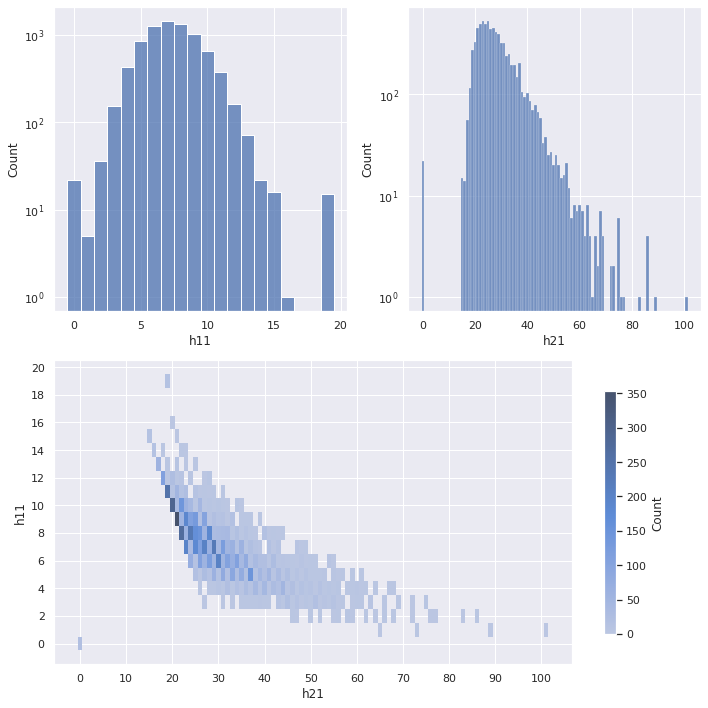

In [103]:
sns.set()
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
ax3.yaxis.set_ticks(range(0,21,2))
ax3.xaxis.set_ticks(range(0,110,10))
sns.histplot(data = df, x = 'h11', ax = ax1, log_scale = (False,True), discrete = True)
sns.histplot(data = df, x = 'h21', ax = ax2, log_scale = (False,True), discrete = True)
sns.histplot(data = df, x = 'h21', y = 'h11', cbar = True, cbar_kws = {'label':'Count','shrink':.80}, ax = ax3, discrete = True)
fig.tight_layout()

<AxesSubplot:>

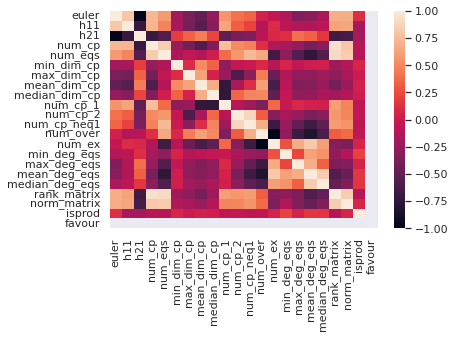

In [104]:
sns.heatmap(df.corr(), xticklabels = 1, yticklabels = 1)

In [105]:
rf = skl.ensemble.RandomForestRegressor()
fNames = ['num_cp', 'num_eqs', 'min_dim_cp', 'max_dim_cp', 'mean_dim_cp', 'median_dim_cp', 'num_cp_1', 'num_cp_2', 'num_cp_neq1', 'num_over', 'num_ex', 'min_deg_eqs', 'max_deg_eqs', 'mean_deg_eqs', 'median_deg_eqs', 'rank_matrix', 'norm_matrix']
xTrain = df[fNames]
yTrain1 = df['h11']
yTrain2 = df['h21']
fImportance = pd.DataFrame()
fImportance['feature'] = fNames
rf.fit(xTrain,yTrain1)
fImportance['h11'] = rf.feature_importances_
rf.fit(xTrain,yTrain2)
fImportance['h21'] = rf.feature_importances_

KeyboardInterrupt: 

In [ ]:
fImportance = pd.melt(fImportance.sort_values(by = 'h11', ascending=False), id_vars = 'feature', var_name = 'number', value_name = 'importance')

<AxesSubplot:xlabel='importance', ylabel='feature'>

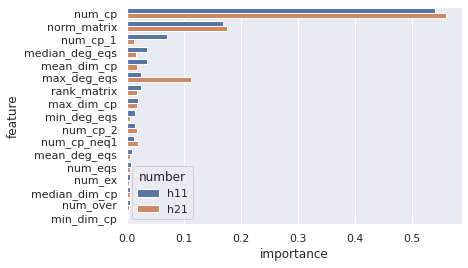

In [ ]:
sns.barplot(data=fImportance, y = 'feature', x = 'importance', ci = None, hue = 'number')

# Neural Network

## Preprocessing

In [148]:
def filter_outliers(data,bounds):
    df = data.copy(deep=True)
    for i in bounds:
        df = df.loc[(df[i]>=bounds[i][0]) & (data[i]<= bounds[i][1])]
    return df

def pad_and_stack(data,size):
    ar = np.ndarray(shape=(len(data),*size))
    for j in range(len(data.values)):
        x = np.array(data.values[j])
        ar[j,:,:] = np.pad(x, [(0,size[i]-x.shape[i]) for i in range(len(size))])
    return ar

In [149]:
df_wo_outliers = filter_outliers(df,{'h11':[1,16],'h21':[1,91]})
df_wo_outliers = df_wo_outliers.sample(frac=1)
matrix_train, matrix_test, h11_train, h11_test, h21_train, h21_test = skl.model_selection.train_test_split(pad_and_stack(df_wo_outliers['matrix'],(12,15)), df_wo_outliers['h11'], df_wo_outliers['h21'], test_size = 0.1, shuffle = False)
matrix_train, matrix_val, h11_train, h11_val, h21_train, h21_val = skl.model_selection.train_test_split(matrix_train, h11_train, h21_train, test_size = 1/9, shuffle = False)

In [159]:
scale = np.max(matrix_train)
matrix_train = matrix_train/scale
matrix_val = matrix_val/scale
matrix_test = matrix_test/scale

## Network

### Class definition

In [174]:
class neural_network():
    def __init__(self,name,input_shape,seq=True):
        self.name = name
        self.seq = seq
        if type(input_shape) == list:
            self.input = [keras.layers.Input(shape=x) for x in input_shape]
            self.seq=False
            self.structure = [self.input]
        elif seq:
            self.input = keras.layers.Input(shape=input_shape)
            self.middle = self.input
        else:
            self.input = [keras.layers.Input(shape=input_shape)]
            self.structure = [self.input]
    
    def add_layer(self,layer,depth=0,branch=0,):
        if self.seq:
            self.middle = layer(self.middle)
        else:
            if len(self.structure) < depth:
                self.structure.append([])
            self.structure[depth+1].append(layer(self.structure[depth][branch]))

    def add_branch(self,layers_list,depth=0,mother_branch=0):
        if self.seq:
            for layer in layers_list:
                self.middle = layer(self.middle)
        else:
            self.add_layer(layer=layers_list[0],depth=depth,branch=mother_branch)
            for i in range(1,layers_list):
                self.add_layer(layer=layers_list[i],depth=i,branch=-1)

    def add_conv_branch(self,layers_size,kernels_size,normalization=0.,dropout=0.,activation='relu',depth=0,mother_branch=0,l1reg=0.,l2reg=0.):
        conv_list = []
        for i in range(len(layers_size)):
            conv_list.append(keras.layers.Conv2D(filters=layers_size[i],kernel_size=kernels_size[i],activation=activation,kernel_regularizer=keras.regularizers.l1_l2(l1=l1reg,l2=l2reg)))
            if normalization > 0:
                conv_list.append(keras.layers.BatchNormalization(momentum=normalization))
            if dropout > 0:
                conv_list.append(keras.layers.Dropout(dropout))
        self.add_branch(conv_list,depth,mother_branch)

    def add_dense_branch(self,layers_size,dropout=0.,normalization=0.,activation='relu',depth=0,mother_branch=0,l1reg=0.,l2reg=0.):
        dense_list = []
        for i in range(len(layers_size)):
            dense_list.append(keras.layers.Dense(units=layers_size[i],activation=activation,kernel_regularizer=keras.regularizers.l1_l2(l1=l1reg,l2=l2reg)))
            if normalization > 0:
                dense_list.append(keras.layers.BatchNormalization(momentum=normalization))
            if dropout > 0:
                dense_list.append(keras.layers.Dropout(dropout))
        self.add_branch(dense_list,depth,mother_branch)

    def merge_branches(self,layer,pos_list=None):
        if pos_list == None:
            pos_list = [(-1,i) for i in range(len(self.structure[-1]))]
        if pos1[0] < pos2[0]:
            depth = pos2[0]
        else:
            depth = pos1[0]
        if len(self.structure) < depth:
            self.structure.append([])
        self.structure[depth+1].append(layer([self.structure[pos1[0]][pos1[1]],self.structure[pos2[0]][pos2[1]]]))

    def close(self,outputs_position):
        self.outputs = []
        if type(outputs_position) == list:
            for i,j in outputs_position:
                self.outputs.append(self.structure[i][j])
        else:
            self.outputs = self.structure[outputs_position[0]][outputs_position[1]]

    def compile(self,optimizer=keras.optimizers.Adam,learning_rate=1e-3,metrics=['mse'],loss='mse'):
        if self.seq:
            self.model = keras.models.Model(inputs=self.input,outputs=self.middle)
        else:
            self.model = keras.models.Model(inputs=self.input,outputs=self.outputs)
        
        self.model.compile(optimizer=optimizer(learning_rate=learning_rate),loss=loss,metrics=metrics)

    def fit(self,x,y,x_val=None,y_val=None,epochs=100,early_stop=10,lr_change=5,batch_size=32):
        callbacks = [keras.callbacks.EarlyStopping(monitor='val_mse',patience=early_stop,restore_best_weights=True,verbose=0),
             keras.callbacks.ReduceLROnPlateau(monitor='val_mse',patience=lr_change,factor=0.3,verbose=0),
             keras.callbacks.ModelCheckpoint(filepath='results/'+self.name+'.h5',monitor='val_mse',save_best_only=True,save_format='h5',verbose=0)
            ]
        history = self.model.fit(x,y,validation_data=(x_val,y_val),epochs=epochs,batch_size=batch_size,callbacks=callbacks)
        self.history = history.history
    
    def predict(self,x):
        prediction = self.model.predict(x)
        return np.round(prediction).astype(int).reshape(-1)
    
    def score(self,x,y):
        pred = self.predict(x)
        return np.sum(pred-y == 0)/len(pred)

### Dense neural network (Bull & al.)

In [175]:
bull_net = neural_network(name='bull_net',input_shape=(12,15))
bull_net.add_layer(keras.layers.Flatten())
bull_net.add_dense_branch(layers_size=[876, 461, 437, 929, 404],dropout=0.2,normalization=0.99)
bull_net.add_layer(keras.layers.Dense(units=1,activation='relu'))
bull_net.compile()


In [ ]:
bull_net.fit(x=matrix_train,y=h11_train,x_val=matrix_val,y_val=h11_val,epochs=5000,early_stop=200,lr_change=75,batch_size=matrix_train.shape[0])

In [ ]:
sns.lineplot(data=[bull_net.history['loss'],bull_net.history['val_loss']]).set(yscale='log',xlabel='epochs',ylabel='mean square error (log)')
plt.legend(labels=['train loss','val loss'])